**Import Modules**

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
%matplotlib inline
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

Using TensorFlow backend.


In [0]:
batch_size = 256  #한번에 학습하는 이미지의 개수
num_classes = 10   #cifar10의 클래스의 개수는 10개
epochs = 50         #학습의 횟수
learning_rate=0.001
data_augmentation = True
num_predictions = 20
model_name = 'keras_cifar10_trained_model.h5'

**Load Data set**

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


**One Hot Encoding [1,0,0,0,0,0,0,0,0,0]의 형태로 만들어준다**

In [0]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

**Function to print images and answers**

In [0]:
import matplotlib.pyplot as plt
def plot_images(x, y_true, y_pred=None, size=(5,5)):
  assert len(x) == len(y_true) == size[0] * size[1]
  fig, axes = plt.subplots(size[0], size[1])
  fig.subplots_adjust(hspace=1, wspace=4)
 
  for i, ax in enumerate(axes.flat):
    
    if x[i].shape[-1] ==1:
      ax.imshow(x[i].reshape(x[i].shape[0], x[i].shape[1]))
    else:
      ax.imshow(x[i])
    if y_pred is None:
      xlabel = "True: {0}".format(y_true[i].argmax())
    else:
      xlabel = "True: {0}, Pred: {1}".format(y_true[i].argmax(),
                                            y_pred[i].argmax())
      
    ax.set_xlabel(xlabel)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
  plt.show()
 

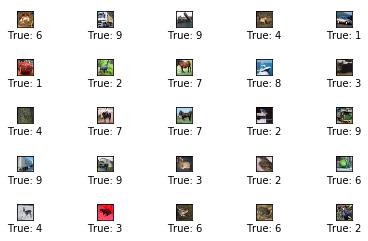

In [7]:
plot_images(x_train[:25], y_train[:25])

**Create model**

In [0]:
model = Sequential()

In [9]:
#convolution layer. 
#input_shape = 32*32, color image

#1번 convolution 레이어: 필터 32개
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
#padding='same'은 출력크기와 입력크기를 같게 하는 것임
model.add(Activation('relu'))

#2번 convolution 레이어: 필터 32개
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

#MaxPooling
model.add(MaxPooling2D(pool_size=(2, 2)))

#과적합 방지
model.add(Dropout(0.25))

#3번 convolution 레이어: 필터 64개
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

#4번 convolution 레이어: 필터 64개
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

#MaxPooling
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))

#5번 convolution 레이어: 필터 128개
model.add(Conv2D(128,(3,3), padding='same'))
model.add(Activation('relu'))

#6번 convolution 레이어: 필터 128개
model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))

#MaxPooling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0,25))

#일차원의 완전연결층으로 변환
model.add(Flatten())

#512개로 줄임
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.5))

#마지막으로 10개의 클래스로 줄임. 출력층
model.add(Dense(num_classes))
model.add(Activation('softmax'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

**Optimizer: learing_rate는 학습속도, decay는 학습 속도를 감소시키는 옵션**

In [0]:
opt = keras.optimizers.rmsprop(lr=learning_rate, decay=1e-6)

**Compile model**

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

**데이터 정규화**

In [0]:

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

**학습시킴**

In [14]:
if not data_augmentation:
    print('Not using data augmentation.')
    
    #batch_size 256, epoch=50으로 설정
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),workers=4, steps_per_epoch=x_train.shape[0]//batch_size)

Using real-time data augmentation.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
195/195 [==============================] - 24s 123ms/step - loss: 2.0837 - acc: 0.2361 - val_loss: 1.7963 - val_acc: 0.3516
Epoch 2/50
195/195 [==============================] - 21s 105ms/step - loss: 1.7406 - acc: 0.3715 - val_loss: 1.4752 - val_acc: 0.4686
Epoch 3/50
195/195 [==============================] - 21s 108ms/step - loss: 1.5569 - acc: 0.4351 - val_loss: 1.3234 - val_acc: 0.5329
Epoch 4/50
195/195 [==============================] - 21s 107ms/step - loss: 1.4204 - acc: 0.4907 - val_loss: 1.2227 - val_acc: 0.5627
Epoch 5/50
195/195 [==============================] - 21s 106ms/step - loss: 1.3143 - acc: 0.5305 - val_loss: 1.1330 - val_acc: 0.5965
Epoch 6/50
195/195 [==============================] - 21s 108ms/step - loss: 1.2241 - acc: 0.5666 - val_loss: 1.0755 - val_acc: 0.6119
Epoch 7/50
195/195 [==============================] - 21s 107ms/step - loss: 1.1466 - acc: 0.5952 - val_los

**테스트 셋으로 평가**

In [15]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 86us/step
Test loss: 0.6391588866233826
Test accuracy: 0.8028


In [0]:
y_pred = model.predict(x_test)

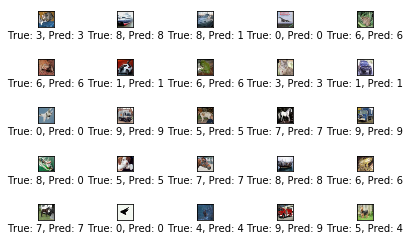

In [17]:
plot_images(x=x_test[:25], y_true=y_test[:25], y_pred = y_pred[:25])

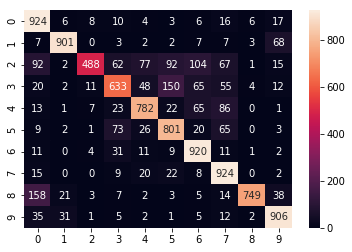

In [18]:
y_result = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(pd.DataFrame(y_result, range(10), range(10)), annot=True, fmt='g')

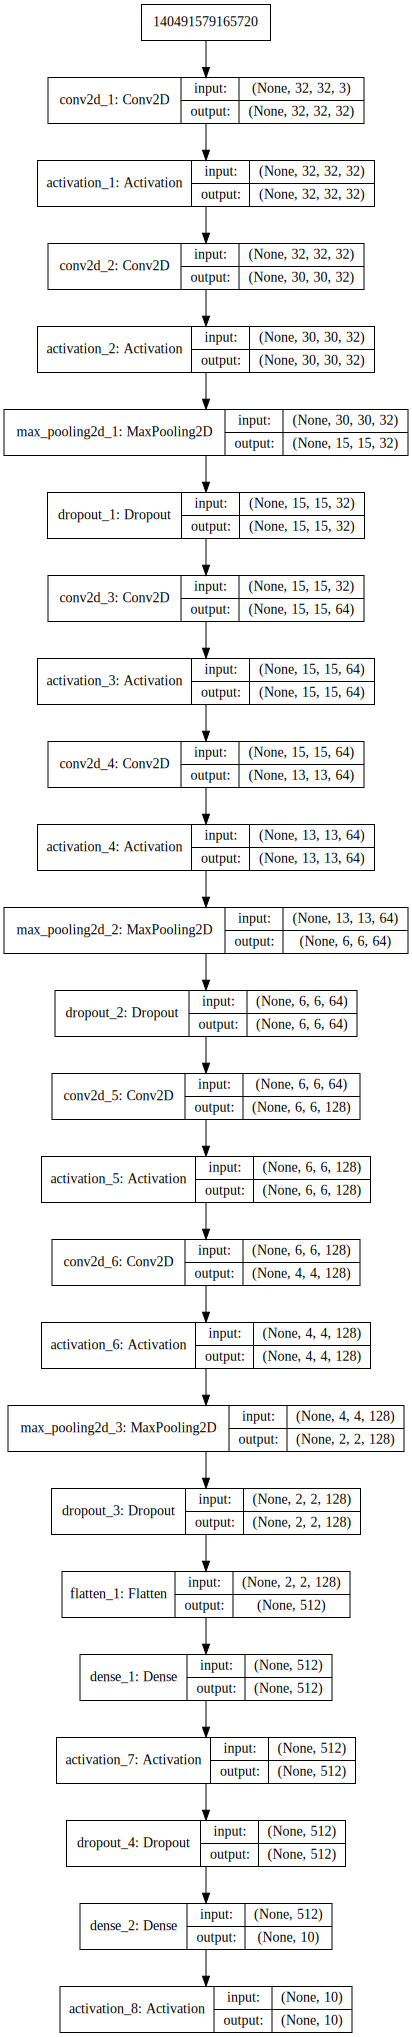

In [19]:
from IPython.display import SVG
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))